# Tutoriel sur les modèles de diffusion

Ce tutoriel a été créé pour aider à comprendre et à utiliser les modèles de diffusion en intelligence artificielle générative.

Il se base notamment sur le livre "Generative Deep Learning" de David Foster (voir le [notebook associé](https://github.com/tomboulier/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/08_diffusion/01_ddm/ddm.ipynb) pour plus de détails), qui lui-même s'inspire du tutoriel [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/) d'András Béres. Je voulais les adapter pour qu'ils utilisent les données de [MedMNIST](https://medmnist.com/).

# Chargement du jeu de données

Nous allons charger le jeu de données MedMNIST pour l'utiliser dans notre tutoriel. En particulier, nous prendrons les radiographies thoraciques (ChestMNIST).

In [1]:
from medmnist import ChestMNIST

train_dataset = ChestMNIST(split="train", download=True)

Maintenant que le jeu de données est chargé, nous allons faire de la visualisation simple pour mieux comprendre son contenu.

In [2]:
# regarder une seule image
img, label = train_dataset[0]
print((img), label)

<PIL.Image.Image image mode=L size=28x28 at 0x7E1A23770FE0> [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Ce sont donc des images au format PIL (Python Imaging Library, déprécié mais dont le fork [Pillow](https://pypi.org/project/pillow/) est largement utilisé). Pour les visualiser avec Matplotlib, nous devons d'abord les convertir en tableaux NumPy.

(28, 28) uint8 [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


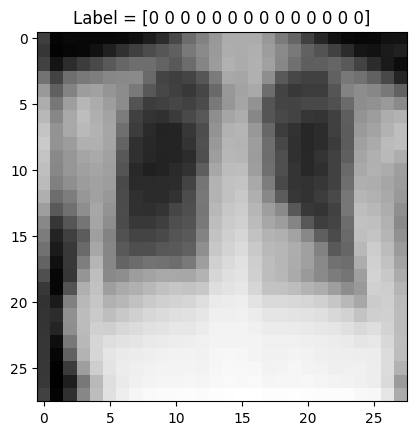

In [3]:
import numpy as np
import matplotlib.pyplot as plt

img, label = train_dataset[0]
img_np = np.array(img)   # conversion en array
print(img_np.shape, img_np.dtype, label)

plt.imshow(img_np, cmap="gray")
plt.title(f"Label = {label}")
plt.show()

# Étape bruitage (forward process)

## Quelques définitions mathématiques

Dans un modèle de diffusion, on part d’une image initiale $x_0$ et on ajoute
progressivement du bruit gaussien pour obtenir une image bruitée $x_t$.

### Les coefficients $\beta_t$ et $\alpha_t$

À chaque étape $t$, on ajoute un peu de bruit à l’image précédente $x_{t-1}$, une fonction que l'on nommera $q$ :
$$
q(x_{t-1} | x_t) = x_t = \sqrt{1 - \beta_t}\,x_{t-1} + \sqrt{\beta_t}\,\varepsilon_{t-1}
$$
où :
- $\varepsilon \sim \mathcal{N}(0,I)$ est un bruit gaussien standard.
- $\beta_t$ est la quantité de **bruit ajoutée** à l’étape $t$.  

On définit par ailleurs $\alpha_t = 1 - \beta_t$ (quantité de **signal conservée** à l’étape $t$).

Exemple :  
- si $\beta_t$ est petit, $\alpha_t \approx 1$ → on garde presque toute l’image.  
- si $\beta_t$ est grand, $\alpha_t$ est petit → on remplace surtout par du bruit.

### Produit cumulatif des $\alpha$

On définit :
$$
\bar{\alpha}_t = \prod_{s=1}^t \alpha_s
$$

$\bar{\alpha}_t$ mesure la **part totale d’image conservée** après $t$ étapes de bruitage.


### Formule du bruitage

On peut ainsi directement écrire :
$$
x_t = \sqrt{\bar{\alpha}_t}\,x_0 \;+\; \sqrt{1-\bar{\alpha}_t}\,\varepsilon
$$

où $\varepsilon \sim \mathcal{N}(0,I)$ est un bruit gaussien standard.


### La notion de planning (*schedule*)

Le **planning** correspond à la manière dont on choisit la suite des $\beta_t$ :  
- **Linéaire** : les $\beta_t$ augmentent régulièrement.  
- **Cosinus, quadratique, etc.** : d’autres courbes sont possibles pour contrôler la vitesse à laquelle le bruit est ajouté.  

Ce choix du planning influence la qualité et la stabilité de l’entraînement.

## Illustration avec MedMNIST

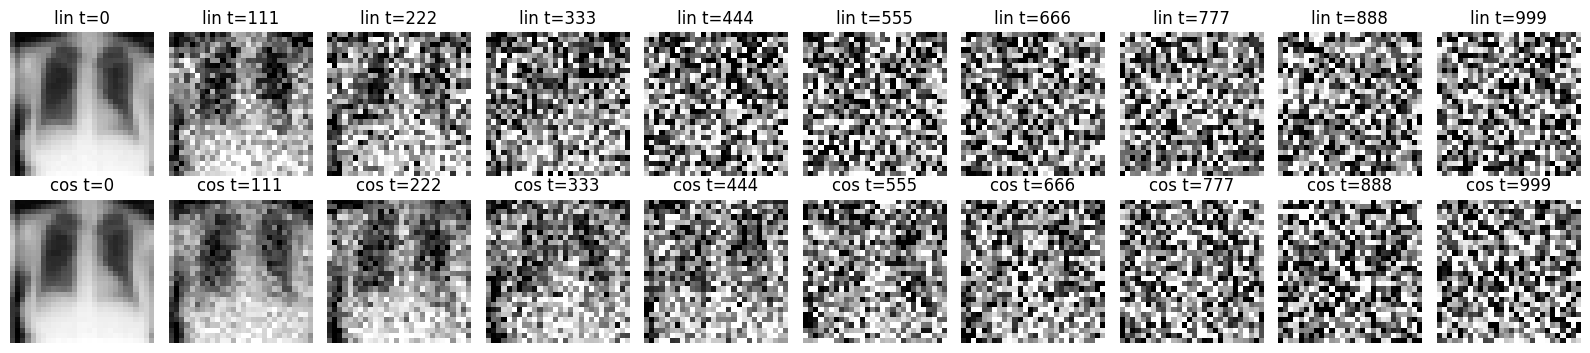

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Plannings: renvoient directement \bar{alpha}_t (alpha_cumprod)
def linear_alpha_cumprod(T=1000, beta_start=1e-4, beta_end=2e-2):
    """
    Calcule le produit cumulatif des alpha_t pour un planning linéaire.
    """
    betas = np.linspace(beta_start, beta_end, T, dtype=np.float32)
    alphas = 1.0 - betas
    alpha_bar = np.cumprod(alphas)
    return alpha_bar

def cosine_alpha_cumprod(T=1000, s=0.008):
    """
    Calcule le produit cumulatif des alpha_t pour un planning cosinus.
    """
    t = np.linspace(0, 1, T+1, dtype=np.float32)
    f = np.cos(((t + s) / (1 + s)) * np.pi / 2) ** 2
    alpha_bar = f[1:] / f[0]    # normalize so alpha_bar[0] ~ 1
    return alpha_bar

# Bruitage direct
def q_sample_single(x0_float_neg1_1, t, alpha_bar):
    """
    Échantillonne une image bruitée à partir de l'image originale et des paramètres de bruit,
    suivant la fonction de bruitage $q(x_{t-1} | x_t)$.
    
    Parameters
    ----------
    x0_float_neg1_1 : array
        L'image originale normalisée entre -1 et 1.
    t : int
        L'étape de bruitage.
    alpha_bar : array
        Le produit cumulatif des alpha_t (défini précédemment par les fonctions de planification).

    Returns
    -------
    array
        L'image bruitée.
    """
    eps = np.random.randn(*x0_float_neg1_1.shape).astype(np.float32)
    return (alpha_bar[t] ** 0.5) * x0_float_neg1_1 + ((1.0 - alpha_bar[t]) ** 0.5) * eps

# Préparation de l'image
# img_np est l'image originale sous forme de tableau numpy, définie dans une cellule au-dessus.
# Son type est un tableau de dimension (28, 28) et de type uint8 -> on normalise en [-1, 1]
x0 = img_np.astype(np.float32) / 127.5 - 1.0

# Paramètres de bruitage
T = 1000 # Nombre total d'étapes de bruitage
n_cols = 10 # Nombre de colonnes à afficher
ts = np.linspace(0, T-1, n_cols, dtype=int) # Étapes de bruitage à afficher

alpha_bar_lin = linear_alpha_cumprod(T) # Produit cumulatif des alpha_t (planning linéaire)
alpha_bar_cos = cosine_alpha_cumprod(T) # Produit cumulatif des alpha_t (planning cosinus)

# Génération des images bruitées
row_lin = [q_sample_single(x0, t, alpha_bar_lin) for t in ts]
row_cos = [q_sample_single(x0, t, alpha_bar_cos) for t in ts]

# Affichage des résultats
plt.figure(figsize=(1.6*n_cols, 3.6))

for i, xt in enumerate(row_lin):
    plt.subplot(2, n_cols, i+1)
    plt.imshow(((xt + 1.0) * 127.5).clip(0, 255).astype(np.uint8), cmap="gray")
    plt.title(f"lin t={ts[i]}")
    plt.axis("off")

for i, xt in enumerate(row_cos):
    plt.subplot(2, n_cols, n_cols + i + 1)
    plt.imshow(((xt + 1.0) * 127.5).clip(0, 255).astype(np.uint8), cmap="gray")
    plt.title(f"cos t={ts[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# Étape de débruitage

L'étape de débruitage consiste à inverser le processus de bruitage en utilisant les étapes de bruitage et les produits cumulés des $alpha_t$. Cela permet de reconstruire l'image originale à partir de l'image bruitée : voir algorithme ci-dessous, tiré de [Ho et al., 2020](https://arxiv.org/abs/2006.11239).

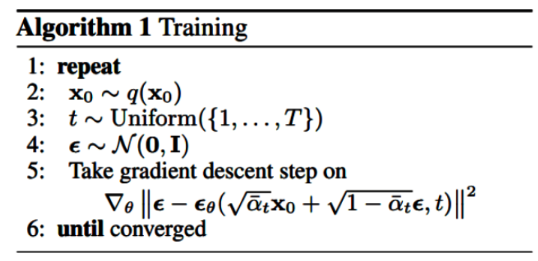

Pour cela, on entraîne un réseau à prédire le bruit à chaque étape de débruitage. Ce réseau est généralement un U-Net, qui prend en entrée l'image bruitée et les informations de temps, et prédit le bruit ajouté à l'image (cf. image ci-dessous).

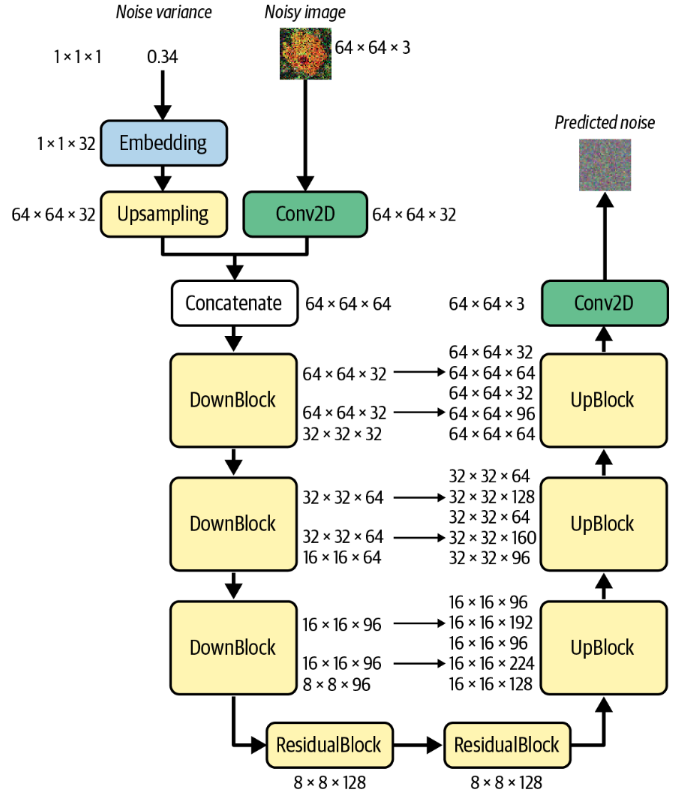

Afin de mieux comprendre ce réseau U-net, nous devons d'abord comprendre les concepts suivants :
- l'encodage sinusoïdal (*sinusoidal embedding*) de la variance du bruit,
- le bloc des résidus (`ResidualBlock`),
- les connexions à saut (*skip connections*),
- les blocs `DownBlock` et `UpBlock`.